#### Objective: Learn how to estimate Average Treatment Effect(ATE) and Conditional Average Treatment Effect(CATE)

In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import plotly.express as px
import plotly.graph_objects as go

In [186]:
import dowhy
from dowhy import CausalModel 

In [187]:
np.random.seed(23)

#### Synthetic Dataset

Dataset that consists of age, pollution exposure, smoking status that affects the lung condition variable. 

In [188]:
# 70% are 0, 30% is 1 
np.random.binomial(1, 0.3)

In [189]:
# 1000 random synthetic samples 
age = np.random.randint(20, 81, size=1000)
pollution_exposure = np.random.uniform(0, 100, size=1000)
smoking_status = np.random.binomial(1, 0.3, size=1000)

In [190]:
# a function to generate lung condition
def lungCondition(age, pollution, smoking):
    risk_factor = age * 0.004 + pollution * 0.007 + smoking * 0.2
    probability_lung_condition = 1/(1+np.exp(-risk_factor))
    return np.random.binomial(1, probability_lung_condition)

In [191]:
lung_condition = np.array([lungCondition(a,b,c) for a,b,c in zip(age, pollution_exposure, smoking_status)])
lung_condition.shape 

In [192]:
df = pd.DataFrame(
    {
        'age':age,
        'pollution_exposure':pollution_exposure,
        'smoking_status':smoking_status,
        'lung_condition':lung_condition
    }
)
df.head()

,age,pollution_exposure,smoking_status,lung_condition
0,60,35.779979,1,0
1,29,93.935741,0,1
2,74,69.526447,0,1
3,60,78.857214,1,1
4,51,50.117081,1,0


In [193]:
df.shape, df['lung_condition'].shape 

In [194]:
df['lung_condition'].value_counts()

lung_condition
1    676
0    324
Name: count, dtype: int64

In [195]:
data_before_causality = df.copy()

Creating a binary treatment variable high_exposure, where `high_exposure=1` if `pollution_exposure>50`.

In [196]:
df['high_exposure'] = np.where(df['pollution_exposure']>50, 1, 0)
df['high_exposure'].value_counts()

high_exposure
0    521
1    479
Name: count, dtype: int64

Introducing a causal relationship, where if `high_exposure=1`, probability of `lung_condition` also increases.

In [197]:
# a function to generate lung condition
def lungCondition2(age, pollution, smoking, high_exposure):
    risk_factor = age * 0.004 + pollution * 0.007 + smoking * 0.2 + high_exposure * 0.3
    probability_lung_condition = 1/(1+np.exp(-risk_factor))
    return np.random.binomial(1, probability_lung_condition)

In [198]:
lung_condition = np.array([lungCondition2(a,b,c,d) for a,b,c,d in zip(age, pollution_exposure, smoking_status, df['high_exposure'])])
lung_condition.shape 

In [199]:
df['lung_condition'] = lung_condition

In [200]:
df['lung_condition'].value_counts()

lung_condition
1    679
0    321
Name: count, dtype: int64

Visualization in `lung_condition` before and after addition of causal relationship 

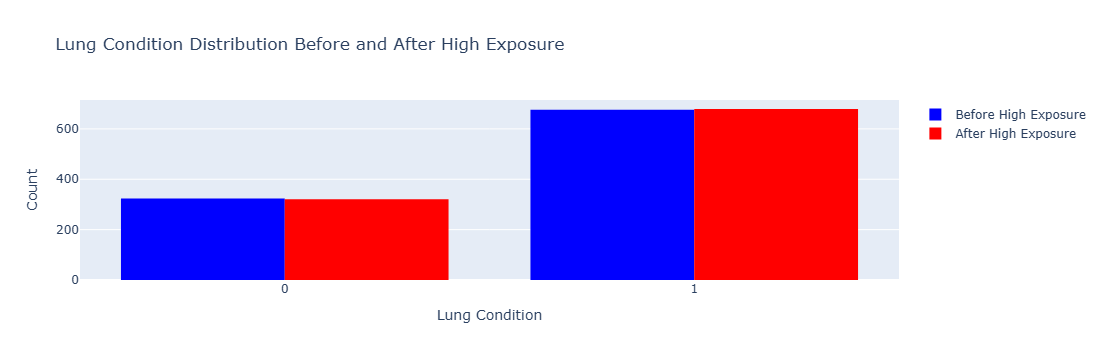

In [201]:
fig = go.Figure()

# before high_exposure
fig.add_trace(go.Histogram(x=data_before_causality['lung_condition'],
                             name='Before High Exposure',
                             marker_color='blue'))

# after high_exposure
fig.add_trace(go.Histogram(x=df['lung_condition'],
                             name='After High Exposure',
                             marker_color='red'))

# Update the layout
fig.update_layout(title='Lung Condition Distribution Before and After High Exposure',
                  xaxis_title='Lung Condition',
                  yaxis_title='Count',
                  bargap=0.2)

fig.show()

Using Dowhy for estimating Average Treatment Effect(ATE) of `high_exposure` on `lung_condition`

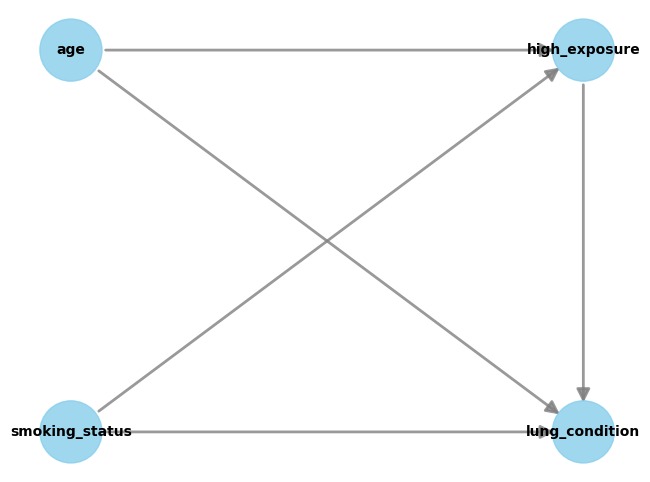

In [202]:
model = CausalModel(
    data=df,
    treatment='high_exposure',
    outcome='lung_condition',
    common_causes=['age', 'smoking_status']
)
model.view_model()

In [203]:
identified_estimand = model.identify_effect(
    proceed_when_unidentifiable=True,
)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                             
───────────────(E[lung_condition|smoking_status,age])
d[highₑₓₚₒₛᵤᵣₑ]                                      
Estimand assumption 1, Unconfoundedness: If U→{high_exposure} and U→lung_condition then P(lung_condition|high_exposure,smoking_status,age,U) = P(lung_condition|high_exposure,smoking_status,age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [204]:
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching"
)
print("Estimated ATE:", estimate.value)

Estimated ATE: 0.177


Here, ATE is positive. Thus, it indicates the estimated impact of high pollution exposure on lung conditions of general people.

* Positive : increases likelihood of outcome
* Zero or near zero : no strong relationship exists
* Negative : negative relation/association

#### CATE: Conditional Average Treatment Effect 

It is calculated for a specific subgroub within the population. It is useful in order to understand if the treatment effect varies for specific groups, learning about the heterogenous treatment effects. i.e. To see if a variable affects different groups differently.

Here, we will see how `high_exposure` affects two subgroups: smokers and non-smokers, on their `lung_condition`.

In [205]:
df_smokers = df[df['smoking_status'] == 1]
model_smokers = CausalModel(
    data=df_smokers,
    treatment="high_exposure",
    outcome="lung_condition",
    common_causes=["age"]
)
identified_estimand_smokers = model_smokers.identify_effect(proceed_when_unidentifiable=True)
estimate_smokers = model_smokers.estimate_effect(
    identified_estimand_smokers,
    method_name="backdoor.propensity_score_matching"
)
cate_smokers = estimate_smokers.value
print("CATE for Smokers:", cate_smokers)

CATE for Smokers: 0.22903225806451613


In [209]:
df_non_smokers = df[df['smoking_status'] == 0]
model_non_smokers = CausalModel(
    data=df_non_smokers,
    treatment="high_exposure",
    outcome="lung_condition",
    common_causes=["age"]
)
identified_estimand_non_smokers = model_non_smokers.identify_effect(proceed_when_unidentifiable=True)
estimate_non_smokers = model_non_smokers.estimate_effect(
    identified_estimand_non_smokers,
    method_name="backdoor.propensity_score_matching"
)
cate_non_smokers = estimate_non_smokers.value
print("CATE for Non-Smokers:", cate_non_smokers)

CATE for Non-Smokers: 0.19855072463768117


### Effect of pollution exposure on lung conditions is slightly higher for smokers (22.9%) compared to non-smokers (19.9%).

Seeing how ATE changes with the change in effect of `high_exposure`

In [207]:
effects = np.linspace(-0.2, 0.6, 20)
ate_values = []
cate_values_smokers = []
cate_values_non_smokers = []

# a function to generate lung condition
def lungCondition3(age, pollution, smoking, high_exposure, effect):
    risk_factor = age * 0.004 + pollution * 0.007 + smoking * 0.02 + high_exposure * effect
    probability_lung_condition = 1/(1+np.exp(-risk_factor))
    return np.random.binomial(1, probability_lung_condition)

for effect in effects:
    lung_condition = np.array([
        lungCondition3(a, b, c, d, effect) 
        for a, b, c, d in zip(age, pollution_exposure, smoking_status, df['high_exposure'])
    ])
    
    df2 = pd.DataFrame({
        'age': age,
        'pollution_exposure': pollution_exposure,
        'smoking_status': smoking_status,
        'high_exposure': df['high_exposure'],
        'lung_condition': lung_condition
    })
    
    model = CausalModel(
        data=df2,
        treatment="high_exposure",
        outcome="lung_condition",
        common_causes=["age", "smoking_status"]
    )
    
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    
    estimate = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.propensity_score_matching"
    )
    ate_values.append(estimate.value)
    
    df_smokers = df2[df2['smoking_status'] == 1]
    df_non_smokers = df2[df2['smoking_status'] == 0]
    
    model_smokers = CausalModel(
        data=df_smokers,
        treatment="high_exposure",
        outcome="lung_condition",
        common_causes=["age"]
    )
    identified_estimand_smokers = model_smokers.identify_effect(proceed_when_unidentifiable=True)
    estimate_smokers = model_smokers.estimate_effect(
        identified_estimand_smokers,
        method_name="backdoor.propensity_score_matching"
    )
    cate_values_smokers.append(estimate_smokers.value)
    
    model_non_smokers = CausalModel(
        data=df_non_smokers,
        treatment="high_exposure",
        outcome="lung_condition",
        common_causes=["age"]
    )
    identified_estimand_non_smokers = model_non_smokers.identify_effect(proceed_when_unidentifiable=True)
    estimate_non_smokers = model_non_smokers.estimate_effect(
        identified_estimand_non_smokers,
        method_name="backdoor.propensity_score_matching"
    )
    cate_values_non_smokers.append(estimate_non_smokers.value)

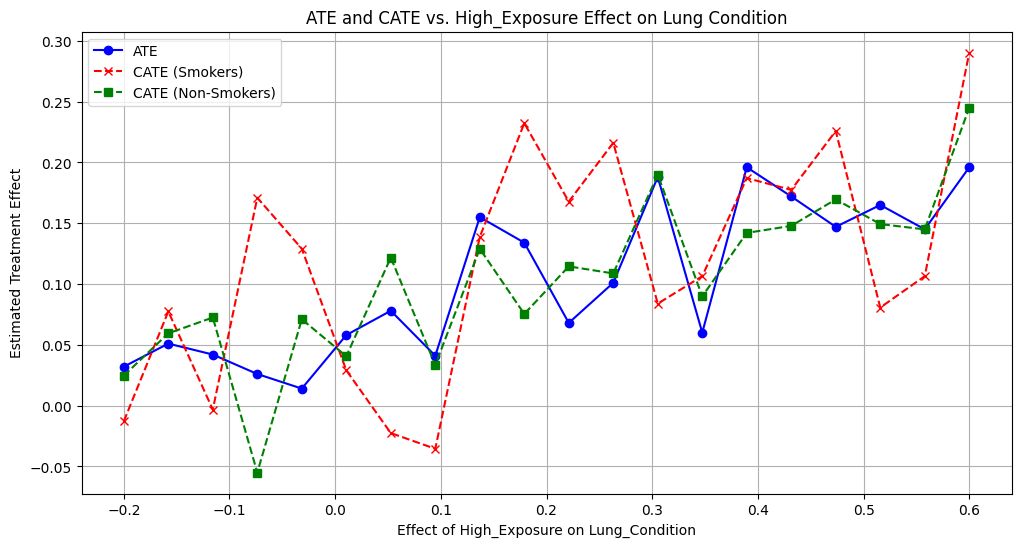

In [208]:
# plots comparing the values
plt.figure(figsize=(12, 6))


plt.plot(effects, ate_values, label="ATE", color='b', marker='o')

plt.plot(effects, cate_values_smokers, label="CATE (Smokers)", color='r', linestyle='--', marker='x')
plt.plot(effects, cate_values_non_smokers, label="CATE (Non-Smokers)", color='g', linestyle='--', marker='s')


plt.xlabel("Effect of High_Exposure on Lung_Condition")
plt.ylabel("Estimated Treatment Effect")
plt.title("ATE and CATE vs. High_Exposure Effect on Lung Condition")
plt.legend()
plt.grid()
plt.show()

The gap between CATE for smokers and non-smokers demonstrates heterogeneous treatment effects. Smokers are generally at a higher risk of developing lung conditions from high pollution exposure than non-smokers. This heterogeneity is critical because it indicates that population averages (ATE) may underestimate the risk for certain groups

ATE is an average, which can mask differences in how subgroups within the population respond to the treatment. This is where Conditional Average Treatment Effect (CATE) becomes valuable. CATE allows us to look at the treatment effect within specific subgroups—like smokers and non-smokers.